# Import necessary libraries to get data from API calls

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import time

In [2]:
# key regenerates every 48 hours, so don't need to hide it
key = 'RGAPI-9a2ff667-3c80-4a26-8a73-d927513e23f1'

# Need to pull in Challenger Players first to be able to get match histories later

In [8]:
challengers = 'https://na1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={}'.format(key)

In [9]:
response = requests.get(challengers)

In [10]:
df = pd.DataFrame(response.json()['entries'])

In [11]:
df.tail()

,freshBlood,hotStreak,inactive,leaguePoints,losses,rank,summonerId,summonerName,veteran,wins
295,False,False,False,602,135,I,GmYgtC1tCu2t90CK0s9UvKRz8dts6-l2rxLg4pD-Gf5VLCBQ,Bobby v9,False,211
296,False,False,False,730,482,I,g6tHviPwKplVrgiRT-IOzB3gUM8xe62w2OJaAuSQ4l174LA,Laceration,True,528
297,True,False,False,541,396,I,WleMIAuEheReQyw_e2M-vPgxTKsbvg2T02r_4JDUZlB_BuE,OhJama,False,427
298,False,True,False,673,67,I,D6H5fjWN1CMKt4SyBQj5B-RiaxlaC7Xb9ZfIeqXqTUOfgZs,BOT KING,False,141
299,False,False,False,530,58,I,bkmdfw0p8hQn9VJBYVS9hyt_wpXuGKrDfFZ67fNplMuH9_8,Dragonminkim,False,66


# EDA of the First API Call

/Users/hiowatah/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


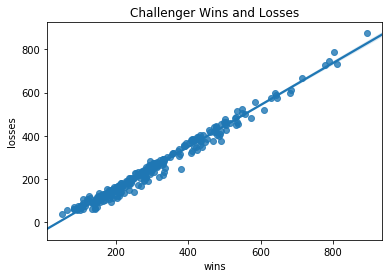

In [12]:
#Plotting the wins and losses for the players in the league
sns.regplot(df.wins, df.losses);
plt.title('Challenger Wins and Losses');

As one might expect, the Win/Loss Ratio seems to follow a line with a slope of < 1. This makes sense as players who win more in this league also equates to other players losing more. The players who lose get demoted to a tier below and are replaced by other players who win their games. Therefore, this league should be consistely filled with players having a positive win loss ratio

Text(0.5, 1.0, 'Number of Players who have played more than 100 games in Challenger')

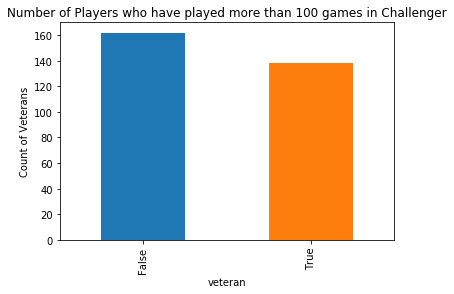

In [13]:
df.groupby('veteran').count()['losses'].plot(kind = 'bar')
plt.ylabel('Count of Veterans')
plt.title('Number of Players who have played more than 100 games in Challenger')

As one might expect, since the churn rate of players in challenger is so high, it would be difficult for players to maintain their rank as one of the best in the league for a long period of time. As such, the number of veterans, or players who have played more than 100 games in the league are less than the number of non veterans

In [14]:
df.describe()

,leaguePoints,losses,wins
count,300.000000,300.000000,300.000000
mean,712.296667,245.633333,293.583333
std,185.186669,148.699464,151.613252
min,462.000000,39.000000,52.000000
25%,569.750000,133.750000,182.000000
50%,658.000000,211.000000,267.000000
75%,815.250000,333.000000,387.250000
max,1604.000000,876.000000,892.000000


# Now that I have my 300 Challenger players, I need to use their summonerIDs to get their AccountIds. Once I obtain that, I can finally get their matchIDs and filter for Qiyana Games

In [15]:
summoner_ids = list(df.summonerId)

In [16]:
summoner_ids[0]

'1NkwHj5gZfxQfnvdu9Pev4XF5jncbESSh3zqTWyWVkEMFLI'

In [22]:
# Creating an empty list of account_ids to add to through continuous API calls from a for loop
account_ids = []

In [23]:
counter = 0
for summoners in summoner_ids:
    url = 'https://na1.api.riotgames.com/lol/summoner/v4/summoners/{}?api_key={}'.format(summoners, key)
    response = requests.get(url)
    account_ids.append(response.json()['accountId'])
    counter +=1
    if counter == 100:
        print(account_ids[-1], len(account_ids))
        time.sleep(120)
        counter = 0

5ySAGwWRDkyJIVil_u0WEbok7ff2uCodUIcw99G3hr12CQ 100
340zkAYCsvcPCquyjwQIz27BeGXH5Hxf2ANZhT6xp75CBQ 200
0kO1lFanftTykU7KSGW3zkC0e32IHxl-J1jY7q7dXIydkQ 300


In [29]:
match_list = []

In [30]:
counter = 0
for accounts in account_ids:
    url = 'https://na1.api.riotgames.com/lol/match/v4/matchlists/by-account/{}?api_key={}'.format(accounts, key)
    response = requests.get(url)
    match_list.append(response.json()['matches'])
    counter +=1
    # Can only do 100 calls per 2 minutes so sleep function to prevent being blocked by API
    if counter == 100:
        print('Limit Reached. total of {} matches'.format(len(match_list)))
        time.sleep(120)
        counter = 0

Limit Reached. total of 100 matches
Limit Reached. total of 200 matches
Limit Reached. total of 300 matches


# Now That I have 30,000 matches I can do some EDA and then filter out for Qiyana games 

In [94]:
platformId = []
gameId = []
champion = []
queue = []
season = []
timestamp = []
role = []
lane = []

In [95]:
for matches in match_list:
    for match in matches:
        platformId.append(match['platformId'])
        gameId.append(match['gameId'])
        champion.append(match['champion'])
        queue.append(match['queue'])
        season.append(match['season'])
        timestamp.append(match['timestamp'])
        role.append(match['role'])
        lane.append(match['lane'])

In [98]:
df2 = pd.DataFrame()

In [99]:
df2['platformId'] = platformId
df2['gameId'] = gameId
df2['champion'] = champion
df2['queue'] = queue
df2['season'] = season
df2['timestamp'] = timestamp
df2['role'] = role
df2['lane'] = lane

In [100]:
df2.tail()

,platformId,gameId,champion,queue,season,timestamp,role,lane
29995,NA1,3066980641,163,420,13,1560574883942,NONE,JUNGLE
29996,NA1,3066939444,64,420,13,1560572326702,NONE,JUNGLE
29997,NA1,3066815495,76,420,13,1560562305896,NONE,JUNGLE
29998,NA1,3066693488,79,420,13,1560550000929,DUO_SUPPORT,NONE
29999,NA1,3066675777,2,420,13,1560547396437,NONE,JUNGLE


In [101]:
df2.describe()

,gameId,champion,queue,season,timestamp
count,3.000000e+04,30000.000000,30000.000000,30000.0,3.000000e+04
mean,3.072009e+09,145.873433,422.529667,13.0,1.561105e+12
std,2.602103e+07,149.427699,22.893702,0.0,1.140443e+09
min,1.624398e+09,1.000000,400.000000,13.0,1.554421e+12
25%,3.067406e+09,42.000000,420.000000,13.0,1.560641e+12
50%,3.074003e+09,89.000000,420.000000,13.0,1.561367e+12
75%,3.080651e+09,164.000000,420.000000,13.0,1.561939e+12
max,3.086997e+09,555.000000,2020.000000,13.0,1.562456e+12


In [102]:
df2.to_csv('Match Histories of Challenger Players.csv')

# Now That I have the 30,000 match histories, I can do high level analysis before diving into Qiyana

In [2]:
match_history = pd.read_csv('Match Histories of Challenger Players.csv')
match_history.drop('Unnamed: 0', axis = 1, inplace=True)
match_history.head()

,platformId,gameId,champion,queue,season,timestamp,role,lane
0,NA1,3084513429,111,420,13,1562228193006,DUO_SUPPORT,BOTTOM
1,NA1,3084446759,69,420,13,1562226080527,SOLO,MID
2,NA1,3084435694,22,420,13,1562223632761,DUO_SUPPORT,NONE
3,NA1,3083216368,18,420,13,1562124451801,DUO_CARRY,BOTTOM
4,NA1,3083201609,4,420,13,1562122608959,DUO_CARRY,BOTTOM


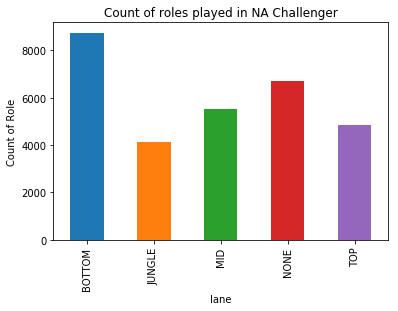

In [3]:
match_history.groupby('lane').count()['champion'].plot(kind='bar')
plt.ylabel('Count of Role')
plt.title('Count of roles played in NA Challenger');

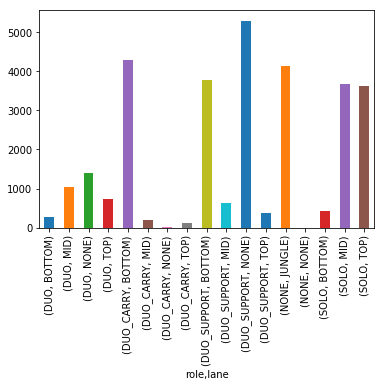

In [4]:
match_history.groupby(['role','lane']).count()['champion'].plot(kind='bar')

In [108]:
match_history.groupby(['lane', 'champion_name']).count().sort_values('queue', ascending = False)['queue'].head(20)

lane    champion_name
BOTTOM  Kaisa            657
        Ezreal           599
        Sivir            552
        Caitlyn          518
        Lux              484
        Karma            387
        Yuumi            362
        Xayah            353
TOP     Irelia           350
BOTTOM  Pyke             317
JUNGLE  LeeSin           301
        Sejuani          301
BOTTOM  Rakan            298
        Sona             294
        Lucian           293
        Nautilus         264
        Thresh           261
        Draven           252
JUNGLE  Olaf             244
TOP     Gangplank        227
Name: queue, dtype: int64

# I only have the champion ID's and I do not know which champion is Qiyana. Using their additional data at ddragon, I can create a dictionary to map the champion names to champion ids and add a new column to my dataframe

In [6]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

In [17]:
df = pd.read_json(champion_names)

In [27]:
champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

In [74]:
champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

In [75]:
champ_dict

{'266': 'Aatrox',
 '103': 'Ahri',
 '84': 'Akali',
 '12': 'Alistar',
 '32': 'Amumu',
 '34': 'Anivia',
 '1': 'Annie',
 '22': 'Ashe',
 '136': 'AurelionSol',
 '268': 'Azir',
 '432': 'Bard',
 '53': 'Blitzcrank',
 '63': 'Brand',
 '201': 'Braum',
 '51': 'Caitlyn',
 '164': 'Camille',
 '69': 'Cassiopeia',
 '31': 'Chogath',
 '42': 'Corki',
 '122': 'Darius',
 '131': 'Diana',
 '36': 'DrMundo',
 '119': 'Draven',
 '245': 'Ekko',
 '60': 'Elise',
 '28': 'Evelynn',
 '81': 'Ezreal',
 '9': 'Fiddlesticks',
 '114': 'Fiora',
 '105': 'Fizz',
 '3': 'Galio',
 '41': 'Gangplank',
 '86': 'Garen',
 '150': 'Gnar',
 '79': 'Gragas',
 '104': 'Graves',
 '120': 'Hecarim',
 '74': 'Heimerdinger',
 '420': 'Illaoi',
 '39': 'Irelia',
 '427': 'Ivern',
 '40': 'Janna',
 '59': 'JarvanIV',
 '24': 'Jax',
 '126': 'Jayce',
 '202': 'Jhin',
 '222': 'Jinx',
 '145': 'Kaisa',
 '429': 'Kalista',
 '43': 'Karma',
 '30': 'Karthus',
 '38': 'Kassadin',
 '55': 'Katarina',
 '10': 'Kayle',
 '141': 'Kayn',
 '85': 'Kennen',
 '121': 'Khazix',
 '203'

In [78]:
match_history['champion_name'] = match_history['champion'].map(lambda x: champ_dict[str(x)] )

In [85]:
match_history.head()

,platformId,gameId,champion,queue,season,timestamp,role,lane,champion_name
0,NA1,3084513429,111,420,13,1562228193006,DUO_SUPPORT,BOTTOM,Nautilus
1,NA1,3084446759,69,420,13,1562226080527,SOLO,MID,Cassiopeia
2,NA1,3084435694,22,420,13,1562223632761,DUO_SUPPORT,NONE,Ashe
3,NA1,3083216368,18,420,13,1562124451801,DUO_CARRY,BOTTOM,Tristana
4,NA1,3083201609,4,420,13,1562122608959,DUO_CARRY,BOTTOM,TwistedFate


In [106]:
match_history.query("champion_name == 'Qiyana'").query("lane == 'NONE'").query("role == 'DUO'")['lane']= 

match_history.query("champion_name == 'Qiyana'").query("lane == 'NONE'").query("role == 'DUO'")['lane'].map(lambda x: 'MID')

It looks like the API isn't perfect as it gives me None values where the player got queued for support. Because the values above makes the most sense to change, since duo is vague enough to change instead of 'Duo_Support' I have updated the values of the dataframe to better reflect Qiyana's true role

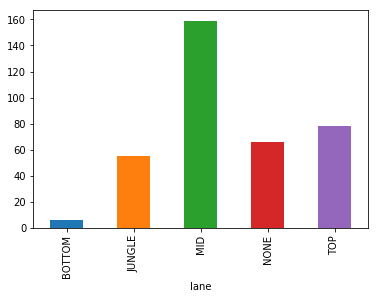

In [107]:
match_history.query("champion_name == 'Qiyana'").groupby('lane').count()['gameId'].plot(kind='bar')

Qiyana is predominantly played in the mid lane, which makes sense since she is a melee assassin champion. This is closely followed by Top and then Jungle. While None, which represents supports, is more popular than Jungle, my guess is that the player ultimately changed roles in the game rather than picking her as a support.

In [112]:
match_history.groupby('champion_name').count().sort_values(by='champion', ascending=False).head(10)

,platformId,gameId,champion,queue,season,timestamp,role,lane
champion_name,,,,,,,,
Kaisa,921,921,921,921,921,921,921,921
Ezreal,845,845,845,845,845,845,845,845
Karma,790,790,790,790,790,790,790,790
Irelia,774,774,774,774,774,774,774,774
Sivir,761,761,761,761,761,761,761,761
Lux,753,753,753,753,753,753,753,753
Caitlyn,710,710,710,710,710,710,710,710
Pyke,586,586,586,586,586,586,586,586
Sylas,582,582,582,582,582,582,582,582
